# Compare Dal's purse seiner model with ours

Note that this doesn't include the distance to shore cutoff in either model.


In the `vessel-scoring` repo:

```
python scripts/make_ps_data_ready_for_dal.py
```

Then in the `dal` repo:

```
Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_ps.measures.from_npz.csv  ../vessel-scoring/dal_ps_results.csv dalhouse/models/timeofday/

```

In [1]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics
import pandas as pd

In [2]:
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [3]:
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [4]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_pseine.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_pseine.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_pseine.dtype)

In [5]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([xtrain, xcross])

xtest = np.concatenate([xtest_pseine])

In [6]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel

untrained_models = [
    ('Logistic', LogisticModel(colspec=dict(windows=[43200]), order=6)),
    ('Logistic (MW)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6)),
    ('Logistic (MW)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6)),
    ('Logistic (MW & daylight)', LogisticModel(
                                    colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                                 measures=['measure_daylight']), order=6)),
    # Using `speed` here rather than `measure_speed` gives terrible results. Overflow? Just way too large?
    ('Logistic (MW & daylight & speed)', LogisticModel(
                                    colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                                 measures=['measure_daylight', 'measure_speed']), order=6)),
    ('Random Forest', RandomForestModel(colspec=dict(windows=[43200]))),
    ('Random Forest (MW)', RandomForestModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]))),
    ('Random Forest (MW & daylight)', RandomForestModel
                                 (colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                               measures=['measure_daylight']))),
    ('Random Forest (MW & daylight & speed)', RandomForestModel
                                 (colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                               measures=['measure_daylight', 'speed']))),
]

trained_models = [(name, train_model_on_data(mdl, train)) for (name, mdl) in untrained_models]

In [7]:
test_mmsi = set(xtest['mmsi'])

In [8]:
predictions = {}

for name, mdl in trained_models:
    predictions[name] = ((mdl.predict_proba(xtest)[:,1] > 0.5), xtest['classification'])

dal_ps_res = pd.read_csv("dal_ps_results.csv")
mask = np.array([(x in test_mmsi) for x in dal_ps_res['mmsi']]).astype(bool)
predictions['dal'] = (dal_ps_res.preds[mask], dal_ps_res.classification[mask])

In [9]:

lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
for name in sorted(predictions):
    pred, actual = predictions[name]
    lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                        metrics.recall_score(actual, pred),
                                        metrics.precision_score(actual, pred), 
                                        metrics.f1_score(actual, pred)))

display(Markdown('\n'.join(lines)))

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic|0.28|0.05|0.08|
|Logistic (MW & daylight & speed)|0.84|0.22|0.35|
|Logistic (MW & daylight)|0.80|0.20|0.32|
|Logistic (MW)|0.62|0.17|0.27|
|Random Forest|0.45|0.08|0.14|
|Random Forest (MW & daylight & speed)|0.85|0.29|0.43|
|Random Forest (MW & daylight)|0.88|0.25|0.38|
|Random Forest (MW)|0.74|0.19|0.30|
|dal|0.76|0.18|0.29|

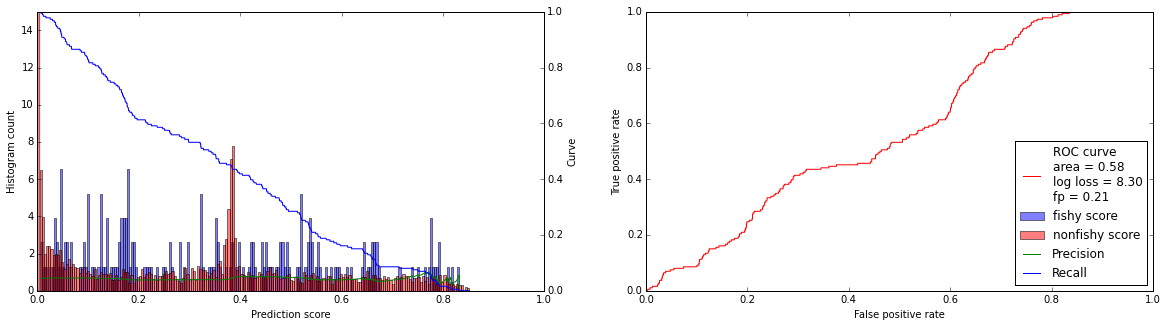

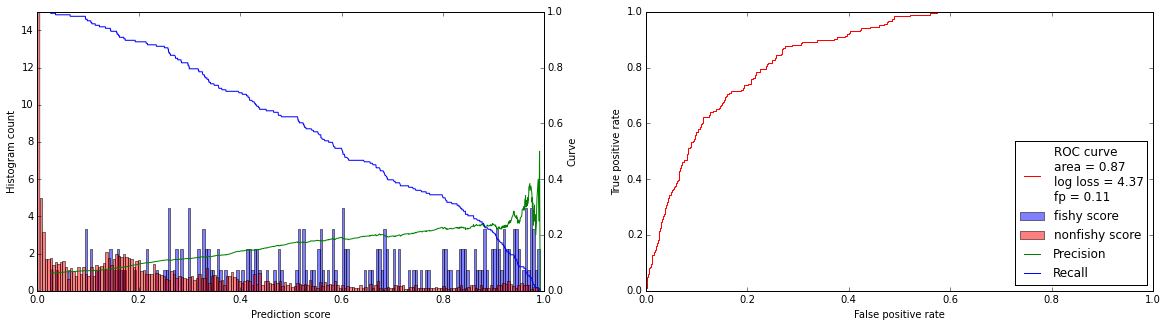

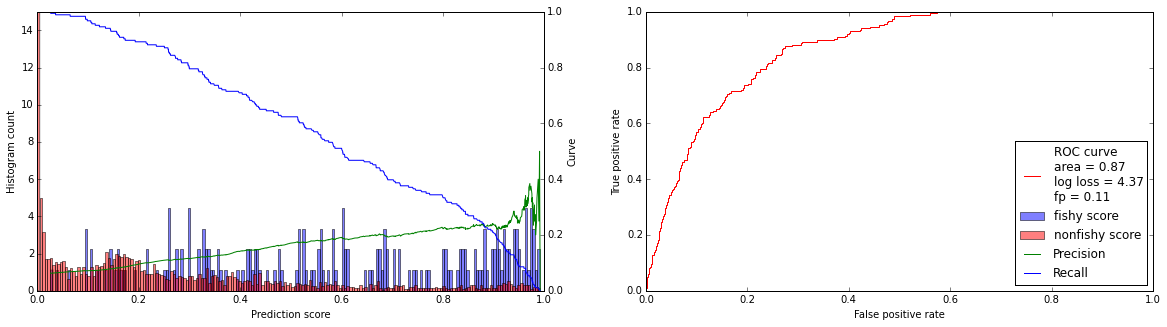

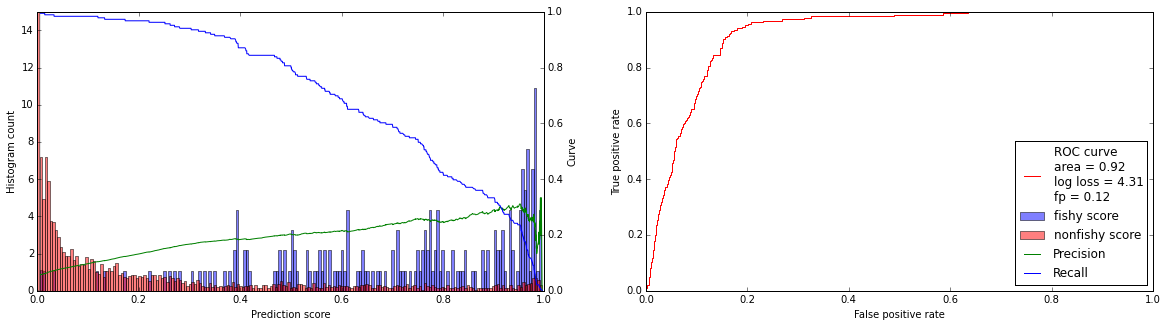

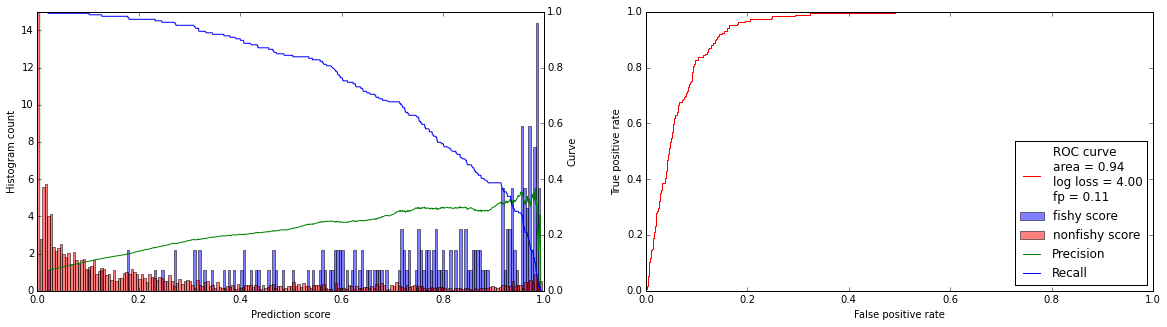

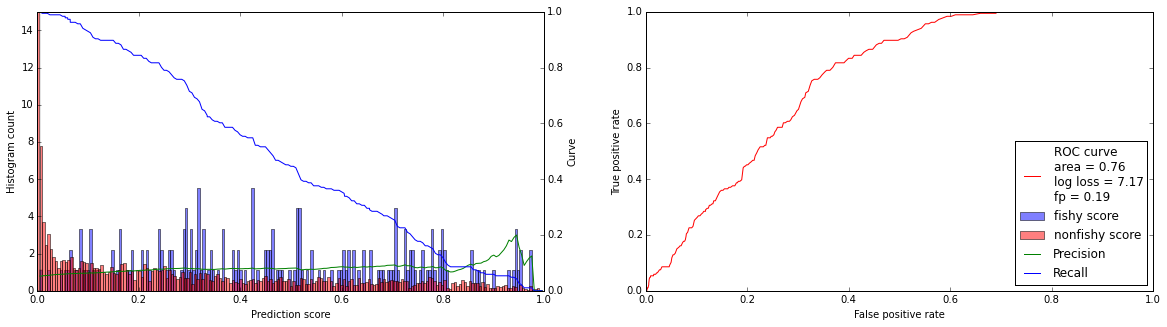

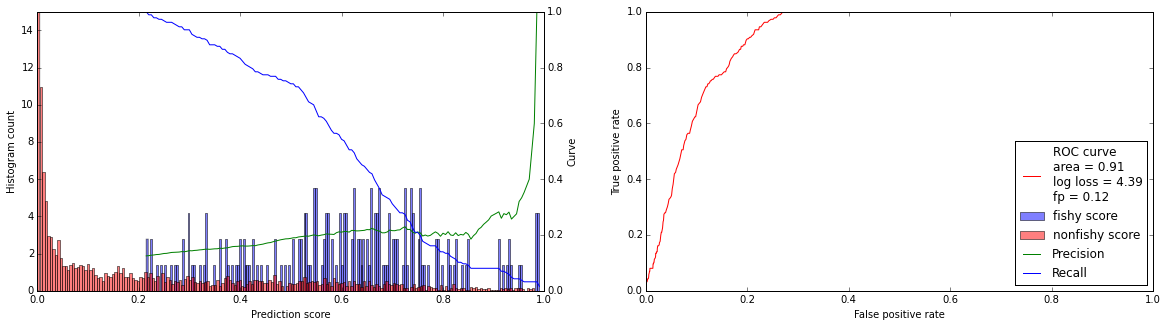

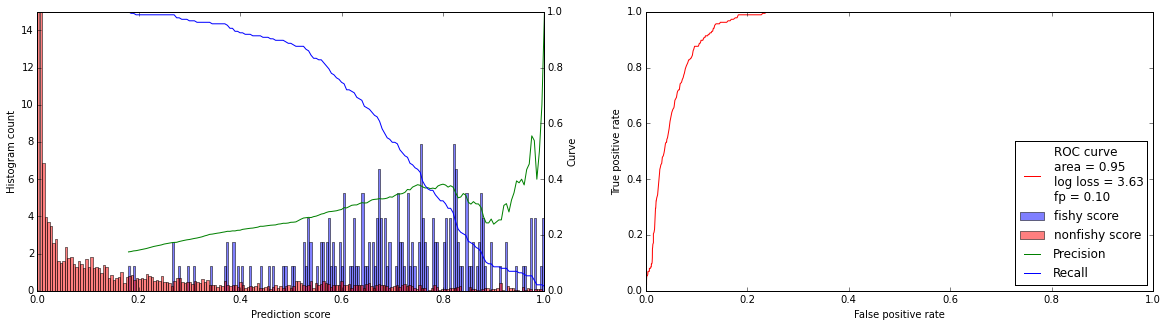

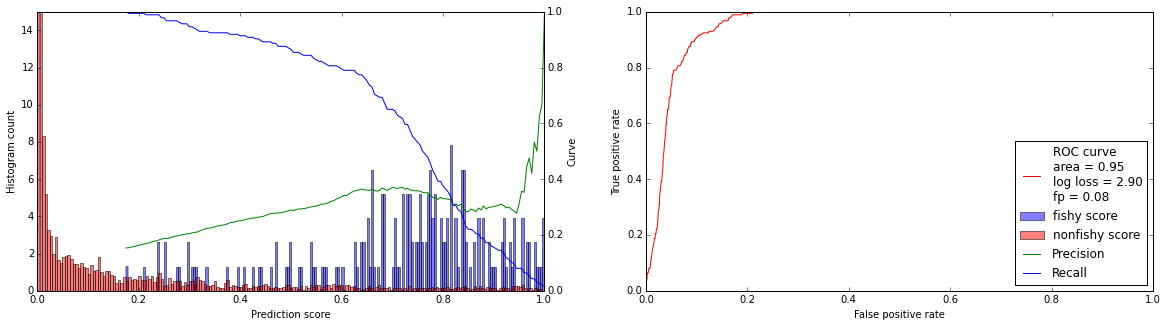

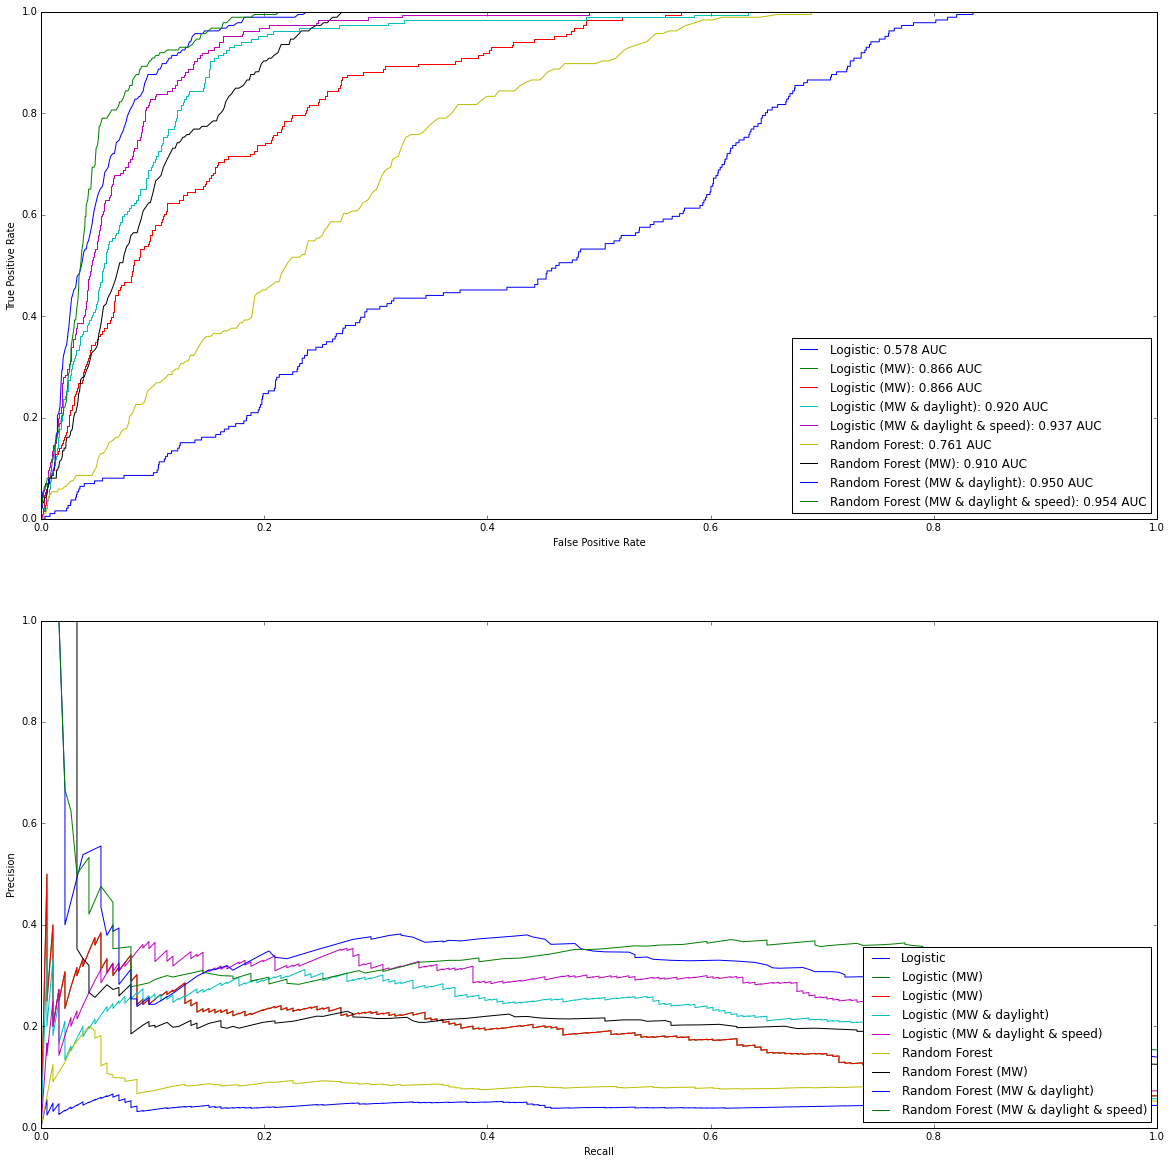

In [10]:

display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in trained_models:
    evaluate_model(mdl, xtest, name=name)

display(HTML("<h1>Overall comparison</h1>"))
compare_models(trained_models, xtest)